1 GP Optimization of a Toy Problem


In [155]:
import numpy as np
import sys
import argparse
from scipy.misc import imread, imsave
import time
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial
import math
import matplotlib.pyplot as plt
import GPy as gp
from scipy.stats import norm
from scipy.optimize import minimize
import gauss_rr as grr
from IPython.display import Image
import importlib as imp
imp.reload(grr)

<module 'gauss_rr' from '/home/benedict/Desktop/2018/aml/aml2018/Exercise_Sheet_5/gauss_rr.py'>

In [61]:
def func(x,y):
    return x**2-x+y**2+y-np.cos(2*np.pi*x-np.pi)-np.cos(2*np.pi*y+np.pi)+2.5



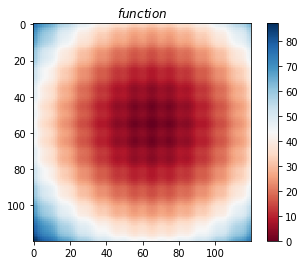

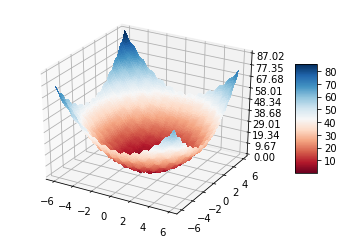

In [100]:
def plot():
    from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
    x = np.arange(-6.0,6.0,0.1)
    y = np.arange(-6.0,6.0,0.1)
    
    X,Y = meshgrid(x, y) # grid of point
    Z = func(X, Y) # evaluation of the function on the grid
    
    im = imshow(Z,cmap=cm.RdBu) # drawing the function
    # adding the Contour lines with labels
    #cset = contour(Z,np.arange(-60,60,0.2),linewidths=2,cmap=cm.Set2)
    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    colorbar(im) # adding the colobar on the right
    # latex fashion title
    title('$function$')
    show()
    
def D_plot():
    from pylab import meshgrid
    x = np.arange(-6.0,6.0,0.1)
    y = np.arange(-6.0,6.0,0.1)
    
    X,Y = meshgrid(x, y) # grid of point
    Z = func(X, Y) # evaluation of the function on the grid
    
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                          cmap=cm.RdBu,linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

plot()
D_plot()

In [101]:
#Expected Improvement
def u(mean_q, var_q, E_best): 
    gamma_q = (E_best - mean_q)/np.sqrt(var_q)
    Phi_gamma_q = norm.cdf(gamma_q)
    phi_gamma_q = norm.pdf(gamma_q)
    utility = np.sqrt(var_q) * (gamma_q * Phi_gamma_q + phi_gamma_q)
    return utility
    


In [107]:
#Initial Training set
import sobol_seq as sobol
NUM_SAMPLES = 30
PARAM_UPPER_LIMS = np.array([6, 6])
PARAM_LOWER_LIMS = np.array([ -6, -6])

x, y = zip(*[sobol.i4_sobol(2, i)[0] * (PARAM_UPPER_LIMS - PARAM_LOWER_LIMS) + PARAM_LOWER_LIMS for i in range(NUM_SAMPLES)])
x = np.array(x)
y = np.array(y)

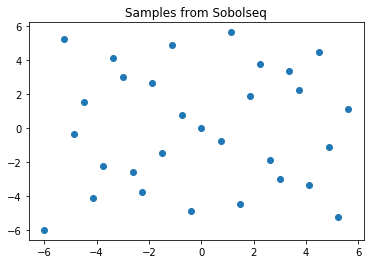

In [109]:
plt.figure()
plt.title("Samples from Sobolseq")
plt.scatter(x, y)
plt.show()

In [121]:
#True function values of initial training set
z_samples = func(x, y)
xy = np.concatenate([x[:, None], y[:, None]], axis=-1)

In [129]:
#Train GP 
kernel = gp.kern.RBF(2) + gp.kern.White(2)
model = gp.models.GPRegression(xy, z_samples[:, None],kernel)
model.optimize(max_iters=100)
model


In [132]:
#Use OPtunity to find points out of X that maximize improvement
import sys
sys.path.insert(0, '/home/benedict/anaconda3/optunity')
import optunity
import optunity.metrics
from pylab import meshgrid

# Grid of points
xx = np.array([-6,6])
yy = np.array([-6,6])

'''
x = np.arange(-6.0,6.0,0.1)
y = np.arange(-6.0,6.0,0.1)
X,Y = meshgrid(x, y) # grid of point
'''


#f = expected_improvement(xx,yy,m)

pars, details, _ = optunity.minimize(func, num_evals=30, x=xx, y=yy)


In [97]:
#Add new point to  training set
qx = pars['x']
qy = pars['y']

qf = func(qx,qy) 
new_point = np.array([qx,qy])
xy_samples = np.append(xy_samples,new_point).reshape(-1,2)



# 2. Reconstruction of Corrupted Image



In [159]:
tau_rho_gamma = (0.8, 3.0, 1.0)
grr.kernel_ridge_regression(*tau_rho_gamma)

array([[124, 136, 146, ...,  71,  71,  72],
       [141, 155, 167, ...,  70,  71,  72],
       [156, 156, 184, ...,  69,  70,  71],
       ...,
       [ 67,  66,  64, ...,  88,  87,  85],
       [ 64,  90,  67, ...,  82,  81,  79],
       [ 71,  71,  70, ...,  78,  77,  75]], dtype=uint8)

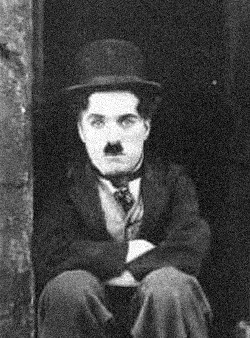

In [160]:
Image(data='./charlie-chaplin.jpg')

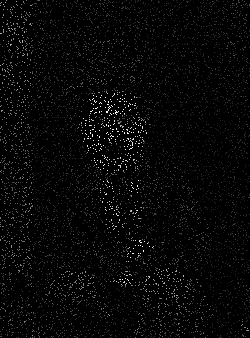

In [161]:
Image(data='./cc_90.png')

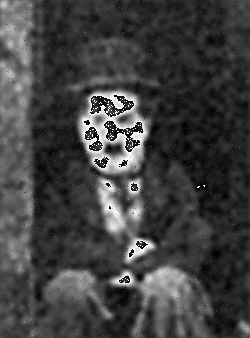

In [165]:
Image(data='./result_cc.png')

For speed up we use a sparse Matrix.


The matrix inverse is inferred via conjugate gradient iteration

##3

In [190]:
def cor(A, B):
    return (((A - A.mean()) * (B - B.mean())).sum()) / (A.std() * B.std())


In [191]:
gt_image = imread('./charlie-chaplin.jpg')

In [198]:
def ground_truth(tau, rho, gamma): 
    predicted_image = grr.kernel_ridge_regression(tau, rho, gamma)
    corr = cor(predicted_image, gt_image)
    return corr


In [193]:
tt, rr, gg = np.meshgrid(np.linspace(0.005, 1, 200), np.linspace(1, 7, 200), np.linspace(1, 4, 200))

In [199]:
UPPER_LIMS = np.array([1, 7, 4])
LOWER_LIMS = np.array([0.005, 1, 1])

t_s, r_s, g_s = zip(*[sobol.i4_sobol(3, i)[0] * (UPPER_LIMS - LOWER_LIMS) + LOWER_LIMS for i in range(NUM_SAMPLES)])
t_s = np.array(t_s)
r_s = np.array(r_s)
g_s = np.array(g_s)

In [ ]:
gt_cors = []
for i, (tau, rho, gamma) in enumerate(zip(t_s, r_s, g_s)): 
    gt_cors.append(ground_truth(tau, rho, gamma))
    print("Iteration {i}, COR = {gt_cors[-1]}")

In [ ]:
c = np.array(gt_cors)[:, None]
trg = np.concatenate([t_s[..., None], r_s[..., None], g_s[..., None]], axis=-1)
gp2 = gp.models.GPRegression(trg, c, gp.kern.Matern52(3))
gp2

In [201]:
gp2.optimize(max_iters=500)
gp2

NameError: name 'gp2' is not defined

In [ ]:
def find_gp2_maxima(cc):
    argmax = np.argmax(cc)
    return (tt.ravel()[argmax], rr.ravel()[argmax], gg.ravel()[argmax]), cc.ravel()[argmax]

def predict_gp2_model(model): 
    ttrrgg = np.concatenate([tt[..., None], rr[..., None], gg[..., None]], axis=-1).reshape(-1, 3)
    cc_mean, cc_var = model.predict(ttrrgg)
    return cc_mean.reshape(tt.shape)

In [203]:
cc = predict_gp2_model(gp2)
(t_max, r_max, g_max), c_max = find_gp2_maxima(cc)
print(f"Best parameters: ({t_max}, {r_max}, {g_max})")

SyntaxError: invalid syntax (<ipython-input-203-fab01ed9ee89>, line 3)

In [186]:
predicted_image = brr.kernel_ridge_regression(t_max, r_max, g_max)

NameError: name 'brr' is not defined

In [188]:
predicted_image_dumb = brr.kernel_ridge_regression(0.8, 3.0, 1.0)

NameError: name 'brr' is not defined

In [202]:
plt.figure(figsize=(10, 10))
plt.title("GP Optimized")
plt.grid(False)
plt.imshow(predicted_image, cmap='gray')
plt.show()

plt.figure(figsize=(10, 10))
plt.title("Fixed Hparams")
plt.grid(False)
plt.imshow(predicted_image_dumb, cmap='gray')
plt.show()

plt.figure(figsize=(10, 10))
plt.title("Ground Truth")
plt.grid(False)
plt.imshow(gt_image, cmap='gray')
plt.show()

NameError: name 'predicted_image' is not defined